In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

In [2]:
J=1
nQ = 7
n_qubits=3*nQ
sqrt_iSWAP = iSwapGate().power(1/2)

dtFactor=0.2
nSteps=30

noise = False
directory="model_NN"

matter_defect = 11

import os
if not os.path.exists(directory):
    os.makedirs(directory)
    

In [3]:
def add3Q(circuit,tmpIndex,alpha=J):
    tmpIndex1=(tmpIndex+1)%(n_qubits)
    tmpIndex2=(tmpIndex+2)%(n_qubits)
    
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    #circuit.barrier()
    circuit.rz(np.pi,tmpIndex)
    circuit.rz(-np.pi/4,tmpIndex1)
    circuit.rz(-np.pi/4,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    
    circuit.rz(np.pi-alpha,tmpIndex1)
    circuit.rz(alpha,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    circuit.rz(np.pi/4,tmpIndex1)
    circuit.rz(np.pi/4,tmpIndex2)
    #circuit.barrier()
            
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    
    
def getTrotterCircuit(n_qubits,J,nTrotter=2,fFactor=0.2,dtFactor=0.2,matter_defect=[6,16]):
    f=fFactor*J
    dt=dtFactor/J
    
    circuit = QuantumCircuit(n_qubits)
    #circuit = QuantumCircuit(n_qubits,n_qubits)
    
    #First produce the initial state:
    for i in range(n_qubits):
        defect_flag=False

        for index in matter_defect:
            if i== index - 1:
                defect_flag=True

        if defect_flag==False:
            if i%2!=0:
                circuit.h(i)
                
            else:
                circuit.x(i)
 
    #Trotterization:
    for step in range(nTrotter):
        
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/4)):
            tmpIndex=i*4
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        n_end=0# no period
        for i in range(int(n_qubits/4)-n_end):
            tmpIndex=i*4+2
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/2)):
            tmpIndex=i*2
            circuit.rz(0,tmpIndex)
            circuit.rx(f*dt,tmpIndex+1)
        #Adding last rotation gate if it is an odd number
        if tmpIndex+1 == n_qubits-2:
            circuit.rz(0,tmpIndex+2)
        
    for i in range(n_qubits):
        if i%2 ==1:
            circuit.h(i)
    
    circuit.measure_all()
    return circuit

In [4]:
aer = AerSimulator()

if noise:
    service = QiskitRuntimeService()
    real_backend = service.backend("ibm_kyoto")
    aer_sim = AerSimulator.from_backend(real_backend)
    estimator_sim = Estimator(mode=aer_sim)
    pm_sim = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
    
else:
    
    estimator_sim = Estimator( mode = aer)
    sampler_sim = Sampler( mode = aer)
    
    pm_sim = generate_preset_pass_manager(backend=aer, optimization_level=3)
    
    


In [5]:
def checkZ2Gauge(key):
    gauge_list = []
    for i in np.arange(1,len(key)-1,1): # Assuming first and last are matter site.
        #assuming matter sites are all even
        #it is backward!

        if i%2 == 0:
            gauge = int(key[i-1])+int(key[i])+int(key[i+1])
            gauge_list.append(gauge%2)

    gauge_list = np.array(gauge_list)
    return gauge_list
  

def checkZ2Charge(key):
    charge = 0
    for i in np.arange(0,len(key),1): # Assuming first and last are matter site.
        #assuming matter sites are all even
        #it is backward!

        if i%2 == 0:
            charge += int(key[i])


    return charge
  

In [6]:

precision = 0.01
circuit = getTrotterCircuit(n_qubits,J,nTrotter=0,fFactor = 1.0,dtFactor=dtFactor,matter_defect=[matter_defect])
isa_qc_sim = pm_sim.run(circuit)
r = sampler_sim.run([(isa_qc_sim,[])],shots=10000).result()
string = r[0].data.meas.get_counts()
key = list(string.keys())[0]

initial_gauge = checkZ2Gauge(key)
initial_charge = checkZ2Charge(key)
#circuit.draw('mpl') 

In [7]:
job = sampler_sim.run([(isa_qc_sim,[])],shots=10000)

In [8]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=10,fFactor = 1.0,dtFactor=dtFactor,matter_defect=[matter_defect])
isa_qc_sim = pm_sim.run(circuit)

r = sampler_sim.run([(isa_qc_sim,[])],shots=10000).result()
string = r[0].data.meas.get_counts()
l_key = list(string.keys())

In [9]:
# print(f"initial gauge sequence {Z2Gauge_initial}")
# for key in list(string.keys()):
#     print('-----')
#     tmp_gauge = checkZ2Gauge(key)
    
#     if abs(tmp_gauge - initial_gauge).sum()==0:
#         print("Gauge agrees")
#     else:
#         print("Gauge not agreeing")
        
        
#     tmp_charge = checkZ2Charge(key)
#     if tmp_charge - initial_charge==0:
#         print("Charge agrees")
#     else:
#         print("Charge not agreeing")
        
#     print('-----')


In [21]:
f = 5
nSteps = 10

string_list = []
print("f = ",f)
for i in range(nSteps):
    print(i)
    t= time.time()
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=f,dtFactor=dtFactor,matter_defect=[11])
    
    isa_qc_sim = pm_sim.run(circuit)


    r= sampler_sim.run([(isa_qc_sim,[])],shots=200000).result()

    string = r[0].data.meas.get_counts()
    string_list.append(string)
    print("time taken = ", time.time() - t)
    


f =  5
0
time taken =  1.3320200443267822
1
time taken =  0.5431389808654785
2
time taken =  0.7592818737030029
3
time taken =  1.039595127105713
4
time taken =  1.2721972465515137
5
time taken =  1.4383909702301025
6
time taken =  1.611471176147461
7
time taken =  1.9109418392181396
8
time taken =  2.145749092102051
9
time taken =  2.3912529945373535


In [22]:
def getEVs(string,gauge_check = False,charge_check=False):
    out = np.zeros(n_qubits)
    shots = 0
    for key in list(string.keys()):
    
        if gauge_check:
            gauge = checkZ2Gauge(key)

            if abs(gauge - initial_gauge).sum()!=0:
                continue
        if charge_check:
            charge = checkZ2Charge(key)
            if charge != initial_charge:
                continue
                
        arr = np.array([int(numeric_string) for numeric_string in key])
        arr = 1 -2*arr #|0> to have eigenValue of 1, and |1> to have -1.
        
        new_charge_pos = -1
        for i in range(arr.shape[0]):
            if i%2==0:
                arr[i] = -arr[i]
                if arr[i] == -1:
                    new_charge_pos = i
        #print(arr,string[key],new_charge_pos)
        out += arr*string[key]
        shots += string[key]
    output = out/shots


    return (output+1)/2

In [23]:
initial_charge_position = n_qubits-matter_defect

initialKey = '101010101000101010101'
initialKey[initial_charge_position]


'0'

In [24]:
def checkZ2Charge_siteOnly(key):
    charge = []
    firstCharge_pos = 0
    for i in np.arange(0,len(key),1): # Assuming first and last are matter site.
        #assuming matter sites are all even
        #it is backward!

        if i%2 == 0:
            charge.append(int(key[i]))
            if int(key[i]) == 0:
                firstCharge_pos = i 
            
    charge = np.array(charge)

    return charge.sum(),firstCharge_pos

def getEVs_siteOnly(string,wiggleRoom = 0,initialKey = initialKey):
    out = np.zeros(n_qubits)
    shots = 0
    for key in list(string.keys()):
                
        charge, charge_position = checkZ2Charge_siteOnly(key)
        
        
        if abs(charge - initial_charge) > wiggleRoom:
            continue
        #print(key,string[key])
             
        tmpKey = np.array([int(numeric_string) for numeric_string in initialKey])  

        if charge_position == initial_charge_position:
            tmpKey = tmpKey #do nothing

        else:
            tmpKey[initial_charge_position] = 1
            tmpKey[charge_position] = 0
            #then flip the links
            
            if charge_position > initial_charge_position:
                for pos in np.arange(initial_charge_position+1,charge_position,1):
                    if pos%2 ==1: #flip link
                        tmpKey[pos] = 1
                        
            else:
                for pos in np.arange(charge_position+1, initial_charge_position,1):
            
                    if pos%2 ==1: #flip link
                        tmpKey[pos] = 1
                  
                
        #print(charge_position, tmpKey, string[key])
        #arr = np.array([int(numeric_string) for numeric_string in tmpKey])
        #arr = 1 -2*arr #|0> to have eigenValue of 1, and |1> to have -1.
        
        arr = 1 -2*tmpKey #|0> to have eigenValue of 1, and |1> to have -1.
        
        for i in range(arr.shape[0]):
            if i%2==0:
                arr[i] = -arr[i]
        

        #print(arr,string[key])
        out += arr*string[key]
        shots += string[key]
    output = out/shots


    return (output+1)/2

In [25]:
evs_list = []
evs_list_siteOnly = []
#evs_list_gauge = []
#evs_list_all= []

for string in string_list:
    evs_list.append(getEVs(string))
    evs_list_siteOnly.append(getEVs_siteOnly(string))
    #print('----')
    #evs_list_gauge.append(getEVs(string,gauge_check = True,charge_check=False))
    #evs_list_all.append(getEVs(string,gauge_check = True,charge_check=True))

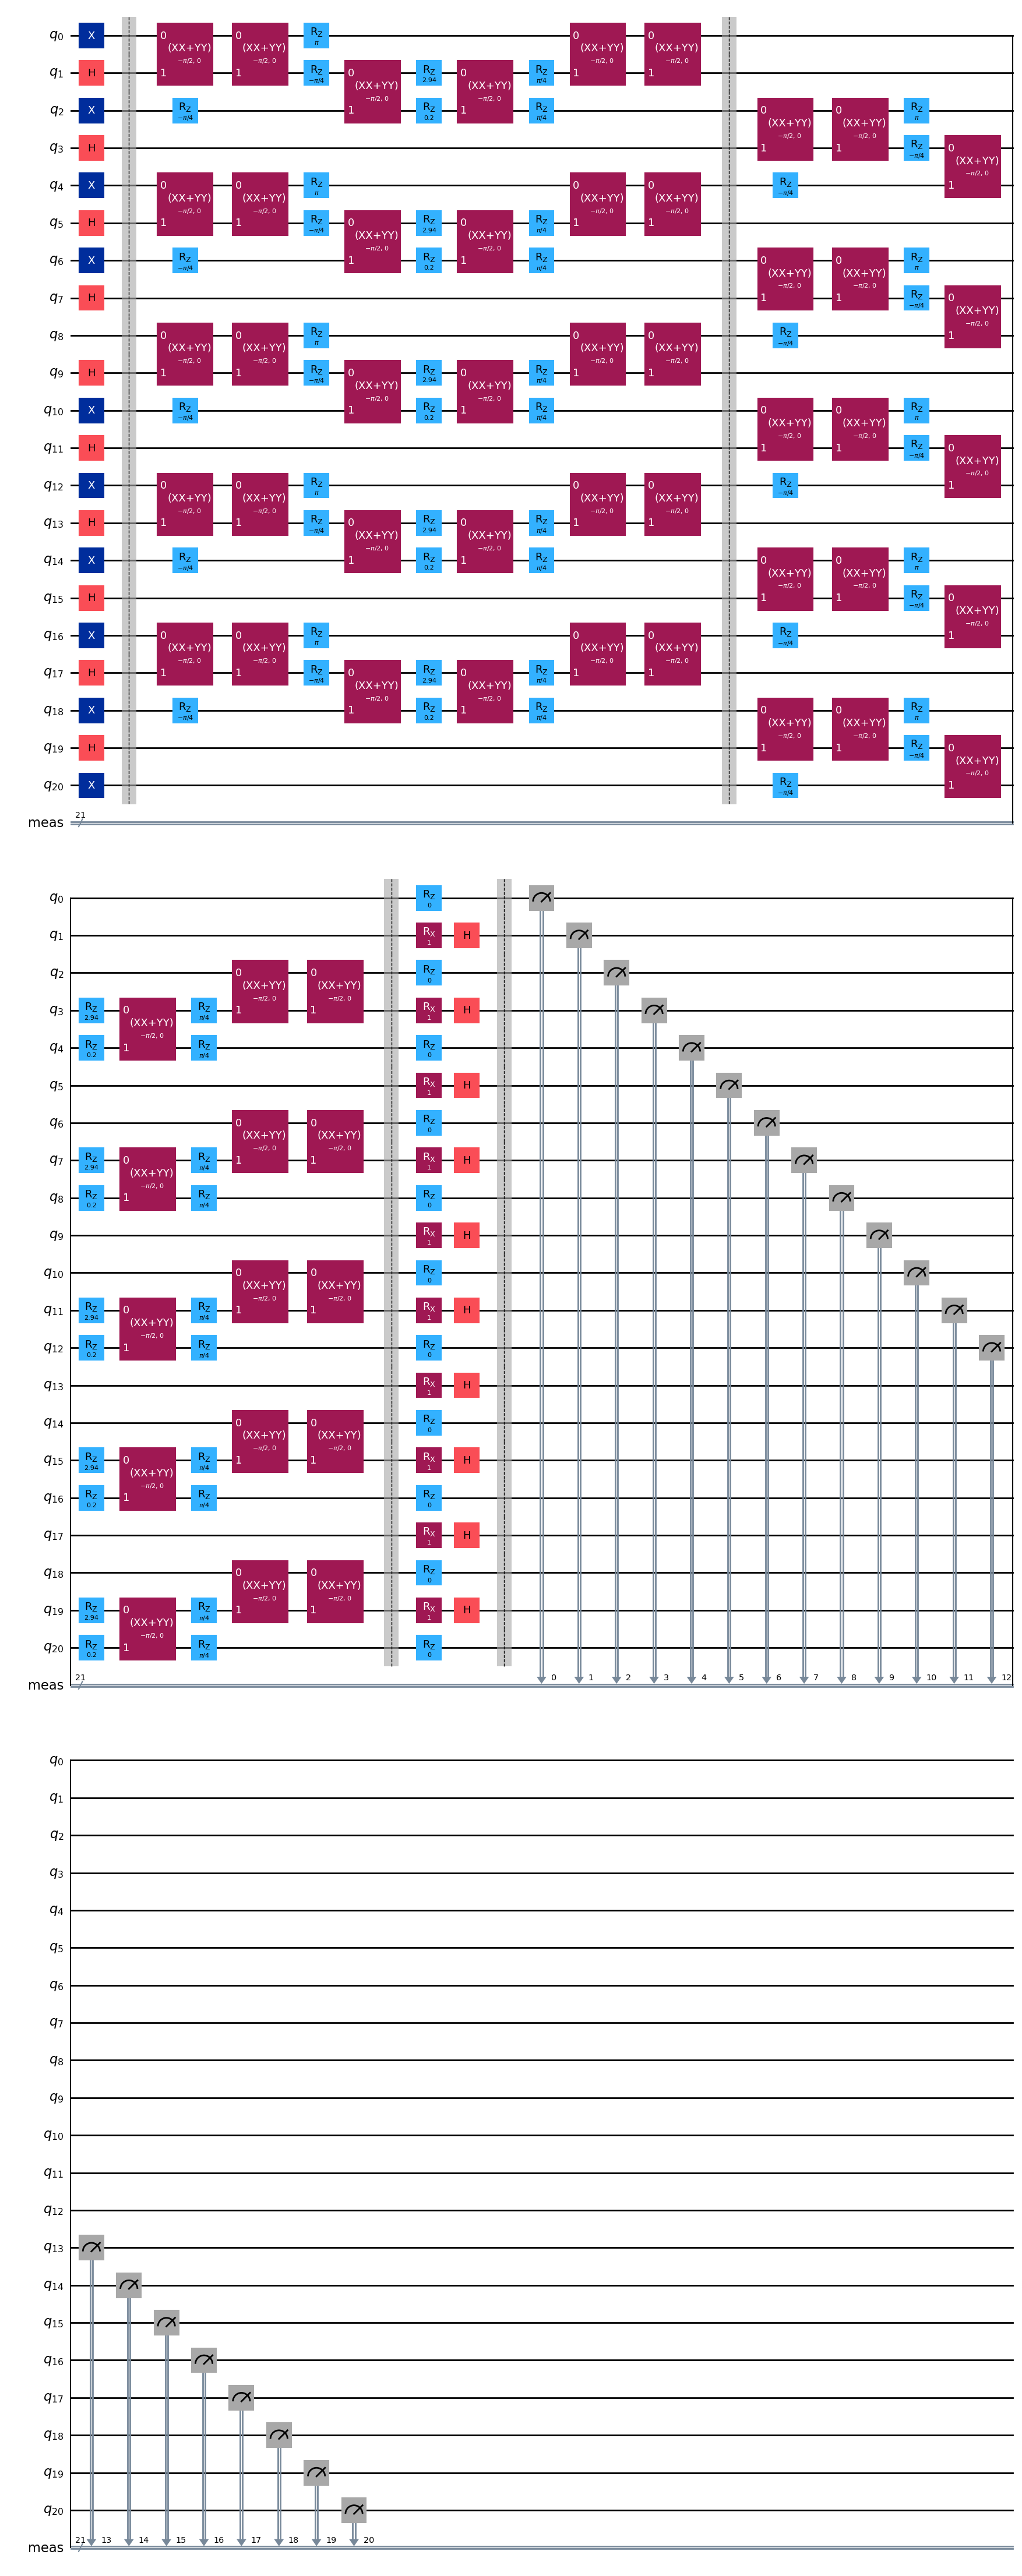

In [26]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=1,fFactor=f,dtFactor=dtFactor,matter_defect=[9])
circuit.draw('mpl')

In [27]:
from matplotlib import colormaps
list(colormaps)
cmap = 'gist_heat'

In [28]:
evs_list[8]

array([1.      , 1.      , 1.      , 1.      , 0.99998 , 0.99998 ,
       0.999095, 0.999075, 0.894175, 0.89325 , 0.247865, 0.858885,
       0.86512 , 0.993765, 0.99381 , 0.999955, 0.999955, 1.      ,
       1.      , 1.      , 1.      ])

<Figure size 640x480 with 0 Axes>

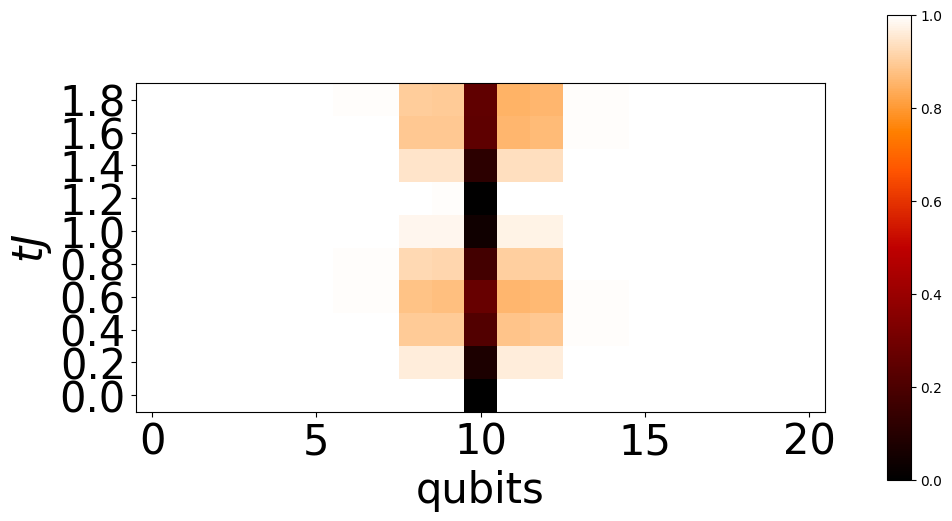

In [29]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(10,10))
plt.imshow(evs_list, interpolation='none',origin='lower',cmap = cmap)

y=dtFactor*J*np.arange(0,len(evs_list),1)
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.colorbar(fraction=0.03, pad=0.08)


plt.savefig(f"deconf_sim_f{f}.png", dpi=100,bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

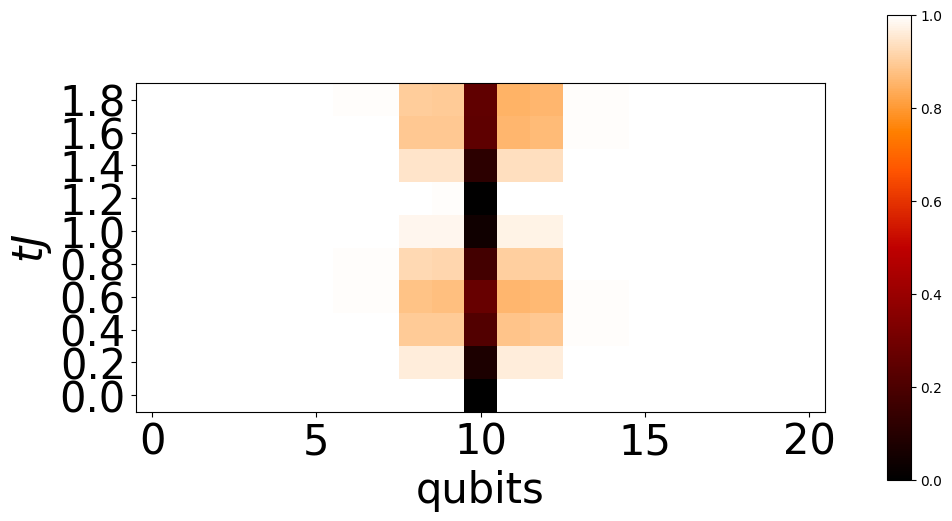

In [30]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(10,10))
plt.imshow(evs_list_siteOnly, interpolation='none',origin='lower',cmap = cmap)

y=dtFactor*J*np.arange(0,len(evs_list),1)
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.colorbar(fraction=0.03, pad=0.08)


plt.savefig(f"deconf_sim_f{f}.png", dpi=100,bbox_inches='tight')

In [31]:
np.save(f"deconf_sim_f{f}_truth.npy",evs_list_siteOnly)

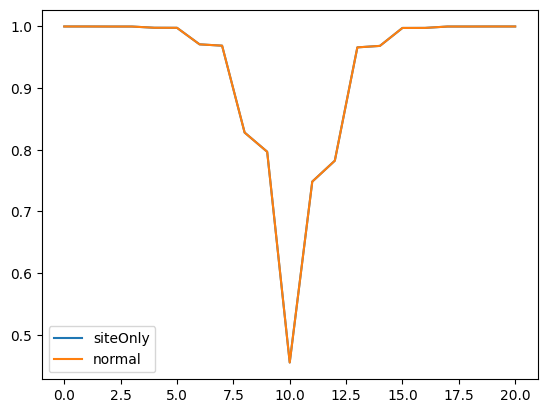

In [80]:
i = 5
plt.plot(np.array(evs_list_siteOnly)[i], label = "siteOnly")
plt.plot(np.array(evs_list)[i], label = "normal")
plt.legend()

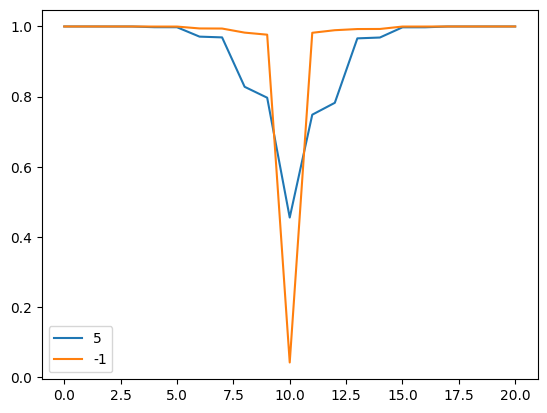

In [81]:
i = 5
plt.plot(np.array(evs_list_siteOnly)[i], label = i)
plt.plot(np.array(evs_list_siteOnly)[-1], label = -1)

plt.legend()

In [82]:
charge_list = []
for i in range(evs_list_siteOnly[-1].shape[0]):
    if i%2 == 0:
        charge_list.append(evs_list_siteOnly[-1][i])
charge_list = np.array(charge_list)

In [62]:
charge_list_5 = []
nnn=8
for i in range(evs_list_siteOnly[nnn].shape[0]):
    if i%2 == 0:
        charge_list_5.append(evs_list_siteOnly[nnn][i])
charge_list_5 = np.array(charge_list_5)

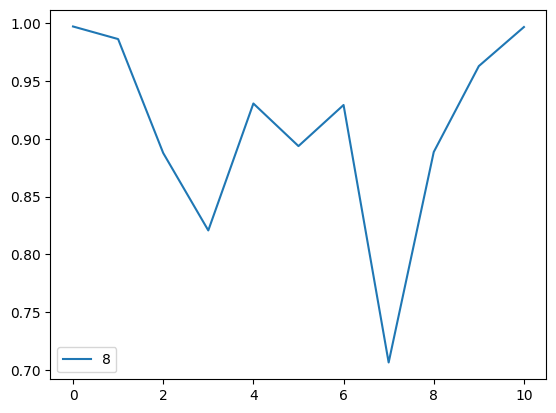

In [63]:
#plt.plot(charge_list)
plt.plot(charge_list_5,label=nnn)
plt.legend()

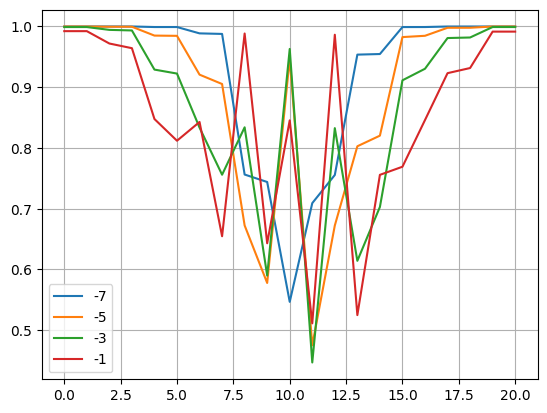

In [64]:
plt.plot(evs_list[-7],label = -7)
plt.plot(evs_list[-5],label = -5)
plt.plot(evs_list[-3],label = -3)
plt.plot(evs_list[-1],label = -1)
#plt.ylim(0,1)
plt.grid()
plt.legend()

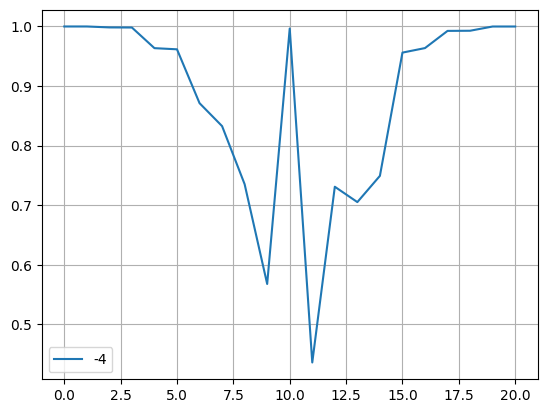

In [65]:

plt.plot(evs_list[-4],label = -4)
#plt.ylim(0,1)
plt.grid()
plt.legend()